In [73]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from glob import glob
import os
import re
import pyemma.msm as msm
import pyemma.coordinates as coor
import numpy as np
import my_network_plot as myplt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import ticker
import operator

# Load the data

Below is the parameters cell for papermill parameterisation:

In [2]:
traj_num = 3
root_dir = 'msm_10ps'

The paths to the relevant objects

In [41]:
data_dir = root_dir+'/output_{}'.format(traj_num)
hmm_paths = glob(os.path.join(data_dir, '*_hmm_obj.pyemma'))
msm_paths = [os.path.join(data_dir, '{}_msm_obj.pyemma'.format(i)) for i in range(1000)]
dtraj_obj_paths = [os.path.join(data_dir, '{}_dtraj_obj.pyemma'.format(i)) for i in range(1000)]
dtraj_paths = [os.path.join(data_dir, '{}_dtraj.npy'.format(i)) for i in range(1000)]


### HMMs

This loads the HMM objects. 

In [42]:
hmms = [msm.MaximumLikelihoodHMSM().load(x) for x in hmm_paths]

This determins which 'chunk' of the trajectory each HMM object pertains to. 

In [43]:
hmm_chunks = [int(re.search('^[0-9]+', os.path.basename(x)).group(0)) for x in hmm_paths]
hmm_chunks[:10]

[2, 994, 981, 882, 27, 127, 132, 784, 868, 208]

In [63]:
no_hmm_chunks = list(set(np.arange(1000)) - set(hmm_chunks))

Now make a dictionary out of them. 

In [44]:
hmms_dict = dict(zip(hmm_chunks, hmms))

### MSMs


Now load the MSMs. There's one for every chunk so we don't need to label them. 

In [45]:
msms = [msm.MaximumLikelihoodMSM().load(x) for x in msm_paths]

This is the conversion between lag in frames (which the MSM object keeps) and the time in ps. 

In [46]:
lag = msms[0].lagtime
dt = np.round(10/lag, 2)
dt 

0.1

## Cluster centers 

In [54]:
ccs = [coor.clustering.KmeansClustering(n_clusters=1).load(x).clustercenters for x in dtrajs_obj_paths]

## Discrete trajectories

In [55]:
dtrajs = [np.load(x) for x in dtrajs_paths]

In [59]:
ccs_all = np.concatenate(ccs, axis=0)
ccs_all.shape

(100000, 3)

## Pruning the timescales. 

We only want to keep those chunks for which the timescales and corresponding HMM meet certain criteria. 

1. The HMM can't contain absorbing states. 
2. The MSM timescales are all longer than the MSM lag time (so are not spurious). 

First let's get the timescales from the MSMs.  This is irrespective of whether they have clear separation or not. We'll keep the first three for clarity. 

In [49]:
msm_timescales = np.concatenate([mm.timescales()[np.newaxis, :3] for mm in msms], axis=0)
msm_timescales.shape

(1000, 3)

HMMs were only created if there was a timescale separation of 1.5. Of these we'll keep those that don't have any `1` on the diagonal of the transition marix. This indicates there was an absorbing state which we're ignoring. We'll call this `hmm_no_abs` i.e. hmm no absorbing state. 

In [50]:
hmm_no_abs = {k : v for k, v in hmms_dict.items() if not np.any(np.diag(v.transition_matrix)==1)}

len(hmm_no_abs)

284

Now calculate the numbthis is the number of metastable states

In [51]:
hmm_n_states = {k: v.nstates for k, v in hmm_no_abs.items()}

We only want thos states for which the slow timescales are longer than the msm lag time. 

In [52]:
hmm_non_spurious = {k: v for k, v in hmm_n_states.items() if msm_timescales[k,v-2] >= lag}

len(hmm_non_spurious)

279

This is a list of lists which gives the chunks which have 2 (and 3, and 4) states. Note, this is different to list in timescales.ipynb


In [66]:
idx_by_n_states = [[k for k, v in hmm_non_spurious.items() if v==i] for i in range(2,5)]
idx_by_n_states = [x for x in idx_by_n_states if len(x) > 0]
idx_by_n_states = [no_hmm_chunks] + idx_by_n_states
len(idx_by_n_states)

4

## MSM plot 

In [74]:
np.random.seed(42)
chunks = []
max_n_states = len(idx_by_n_states)
chunks = [(i+1, np.random.choice(idx_by_n_states[i])) for i in range(max_n_states)]
chunks = sorted(chunks, key=operator.itemgetter(1))
chunks

[(2, 83), (4, 119), (3, 232), (1, 250)]

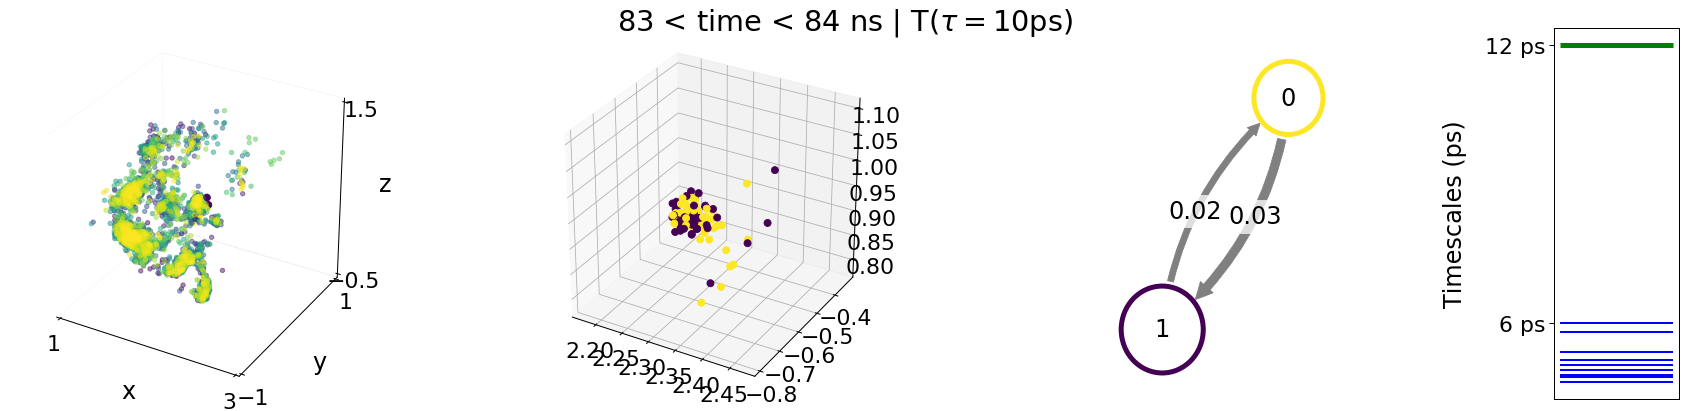

In [118]:

def axis_labs(ax):
    ax.set_xlim(1,3.); ax.set_ylim(-1, 1.); ax.set_zlim(-0.5, 1.5)
    ax.set_xlabel('x', labelpad=10); ax.set_ylabel('y', labelpad=10); ax.set_zlabel('z', labelpad=10)
    ax.xaxis.pane.fill=False; ax.yaxis.pane.fill=False; ax.zaxis.pane.fill=False
    ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(locs=[1,3]))
    ax.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(locs=[-1,1]))
    ax.zaxis.set_major_locator(matplotlib.ticker.FixedLocator(locs=[-0.5,1.5]))
    ax.grid(False)
    return ax

with sns.plotting_context('paper', font_scale=2.5):

    # Get the relevant data
    idx = chunks[0][1]
    hmm = hmms_dict[idx]

    N = hmm.nstates
    obs_to_hid = np.argmax(hmm.metastable_memberships, axis=1)
    m_assign = hmm.metastable_assignments

    pi = hmm.pi

    # Position data
    stride=10
    traj = ccs_all
    traj_idx = ccs[idx]
    
    # Set up figure and axes
    scale=1.5
    fig = plt.figure(figsize=(scale*16, scale*4))
    gs = fig.add_gridspec(1, 4,
                       width_ratios=[3,3,3,1])
    ax1 = fig.add_subplot(gs[0],projection='3d')
    ax1a = fig.add_subplot(gs[1],projection='3d')
    ax2 = fig.add_subplot(gs[2])
    ax3 = fig.add_subplot(gs[3])

    fig.suptitle('{0} < time < {1} ns'.format(idx, idx+1) + r' | T($\tau={:4.0f}$ps)'.format(np.round(hmm.lag*dt, -1)), 
                 horizontalalignment='center', verticalalignment='top')

    # Set up colors    
    cmap_use = 'viridis_r'
    cmap = matplotlib.cm.get_cmap(cmap_use,N)
    cols = [cmap(n) for n in range(N)]

    # cluster centers
    ax1a.scatter(xs=traj_idx[:,0], ys=traj_idx[:,1], 
                zs=traj_idx[:,2], alpha=1, c=m_assign,
               zorder=2, s=50, cmap=cmap) 

    ax1.scatter(xs=traj_idx[:,0], ys=traj_idx[:,1], 
                zs=traj_idx[:,2], alpha=1, c=m_assign,
               zorder=2, s=50, cmap=cmap) 
    
    # Whole trajectory
    T = traj[::stride, 0].shape[0]
    
    ax1.scatter(xs=traj[::stride,0], ys=traj[::stride,1],
               zs=traj[::stride,2], alpha=0.5, s=20, zorder=1, c=np.arange(T))
    ax1 = axis_labs(ax1)

    # Network
    r = 0.8
    x = np.array([r * np.cos(2*np.pi*n/N + np.pi/6) for n in range(N)])
    y = np.array([r * np.sin(2*np.pi*n/N + np.pi/6) for n in range(N)])
    pos = np.concatenate((y[:,np.newaxis], x[:, np.newaxis]), axis=1)
    _, _ = myplt.plot_markov_model(hmm.transition_matrix, ax=ax2, 
                                  arrow_curvature=3, state_colors=cols,
                                  arrow_label_format = '%2.2f',pos=pos,
                                  figpadding=0.3, arrow_scale=0.5, state_scale=2)

    # Timescale plots
    mm = msms[idx]
    t_max = 10
    ts = mm.timescales()[:t_max]*dt

    # Slow:
    ax3.hlines(ts[0], 0, 1, lw=5, color='g', label='Slow')
    for i in range(1,N-1): 
        ax3.hlines(ts[i], 0, 1, lw=5, color='g')
    # Fast
    ax3.hlines(ts[N-1], 0, 1, lw=2, color='b', label='Fast')
    for i in range(N-1,t_max): ax3.hlines(ts[i], 0, 1, lw=2, color='b')
    
    # Labels
    ax3.set_yscale('log')
    ax3.set_ylabel('Timescales (ps)')
    
    # Tick marks for timescale plots
    locator = matplotlib.ticker.FixedLocator(locs=ts[:N], nbins=N)
    formatter = matplotlib.ticker.StrMethodFormatter('{x:4.0f} ps')
    ax3.yaxis.set_major_formatter(formatter)
    ax3.yaxis.set_major_locator(locator)
    ax3.tick_params(which='minor', labelleft=False, left=False)
    ax3.tick_params(which='major', labelbottom = False, bottom=False)

    plt.tight_layout()
    fig.subplots_adjust(hspace=0.1)


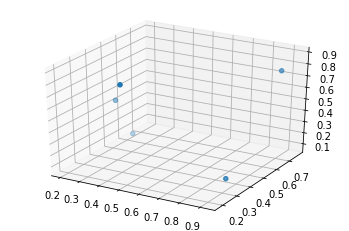

In [159]:
np.random.seed(5)
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(np.random.random(5), np.random.random(5), np.random.random(5))
# ax.spines['bottom'].set_position(['data', -.5])
ax.spines['bottom'].visible=True

In [127]:
ax.spines

OrderedDict([('left', <matplotlib.spines.Spine at 0x12b3b5b38>),
             ('right', <matplotlib.spines.Spine at 0x120376470>),
             ('bottom', <matplotlib.spines.Spine at 0x120376780>),
             ('top', <matplotlib.spines.Spine at 0x120376278>)])